# Connectivity matrix

So Sir provided some functional connectivity matrices (features) extracted from the data. These represent connectivity between different frequency bands. Let me import and visualise this. After that I'll translate it into a nice set of features which I can then utilise for my model.

In [27]:
import scipy.io
mat_data = scipy.io.loadmat('fconn_test_data/resting_eeg_fconn_0002.mat')
print(mat_data["fconn"].shape)

(30, 30, 17)


17 frequencies are mentioned here: [4 5 6 8 10 12 15 20 25 30 35 40 50 60 70 80 100]
I'm guessing the functional connectivity represents 30 x 30 x 17, ie, for each frequency, there is a 30x30 matrix representing the coherence of different channels at that frequency.

In [28]:
mat_data["freqVec"]

array([[  4,   5,   6,   8,  10,  12,  15,  20,  25,  30,  35,  40,  50,
         60,  70,  80, 100]], dtype=uint8)

In [29]:
conn_matrix = mat_data["fconn"][:,:,3]
for i in range(5):
    print(conn_matrix[i][i])

print("Shows that highest connectivity value is 1, similar to a correlation matrix")

1.0
1.0
1.0
1.0
1.0
Shows that highest connectivity value is 1, similar to a correlation matrix


/var/folders/hr/cn8gd6d15xv_6m22yptdtyhw0000gn/T/ipykernel_42708/3178972781.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


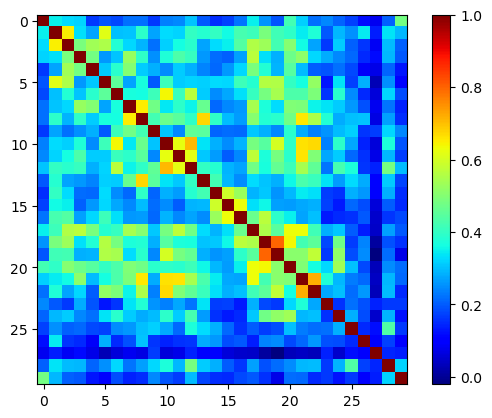

In [30]:
import numpy as np
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('jet') 

plt.imshow(conn_matrix, cmap=cmap)
plt.colorbar()
plt.show()

In [31]:
ranges = [(0, 0.1), (0.1,0.2), (0.2, 0.3), (0.3,0.4), (0.4, 0.5), (0.5,0.6), (0.6, 0.7), (0.7, 0.8)]
connectivity_counts = []

for r in ranges:
    count = np.sum((conn_matrix >= r[0]) & (conn_matrix < r[1]))
    connectivity_counts.append(count)

# Print the connectivity counts for each range
for i, r in enumerate(ranges):
    print(f"Connectivity in range {r}: {connectivity_counts[i]}")

Connectivity in range (0, 0.1): 42
Connectivity in range (0.1, 0.2): 156
Connectivity in range (0.2, 0.3): 250
Connectivity in range (0.3, 0.4): 212
Connectivity in range (0.4, 0.5): 114
Connectivity in range (0.5, 0.6): 56
Connectivity in range (0.6, 0.7): 32
Connectivity in range (0.7, 0.8): 6


I think I'll take a 0.3 threshold for reasonable connectivity and to create an edge. And I will weight the edges as the inverse of connectivity (this will be used to compute distances, since the inverse of connectivity represents the inverse of strength, ie, distance).
Number of nodes and edges will be based on the threshold.
Degree of nodes will be weighted by the connectivity values.
Centrality of nodes will be computed as a betweenness centrality based on distances (1/connectivity). By finding the number of shortest paths between other nodes that that node lies on, we know that that node is quite central, ie, many nodes find strong connections to that node and would communicate first with that node to access any other node.

So these features for each channel needs to be extracted, and the total number of edges is extracted separately.

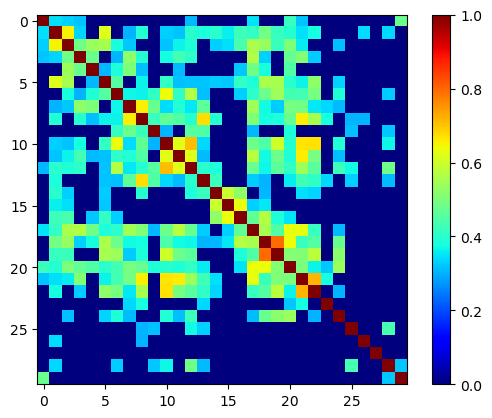

In [32]:
# Setting threshold of 0.3
conn_thresh = np.where(conn_matrix < 0.3, 0,conn_matrix)
plt.imshow(conn_thresh, cmap=cmap)
plt.colorbar()
plt.show()

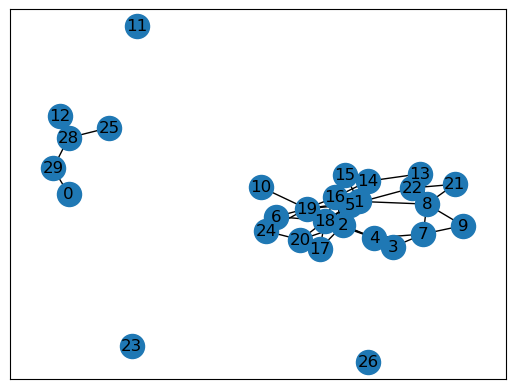

In [33]:
import networkx as nx

# graph = np.where(conn_thresh == 0, 0, 1 / conn_thresh)

G = nx.from_numpy_array(graph)
G.remove_node(27)

nx.draw_networkx(G, with_labels=True)

In [8]:
feats = np.zeros((17,30,3))

degrees = np.zeros((17,30))
degrees[:] = -1

# Computing degree of nodes
for i in range(17):
    graph = mat_data["fconn"][:,:,i]
    graph = np.where(graph < 0.3, 0,graph)
    for j in range(30):
        jgraph = graph[j,:]
        for k in range(30):
            conn = jgraph[k]
            degrees[i,j] += conn

print(degrees[3])
feats[:,:,0] = degrees

[ 2.86470258  8.37481725  8.12501317  6.26279283  4.47354168  7.83567357
  8.43357176  7.92804706  9.2267268   3.85245481  8.87537432  7.81589696
  9.69175971  6.86751306  4.36177713  2.93896839  4.86780062 10.16019762
  9.5730972   7.92817071  9.83433726  9.25838292  7.81437001  1.75459054
  4.61807173  1.75653124  0.64750534  0.          2.91198781  0.79859534]


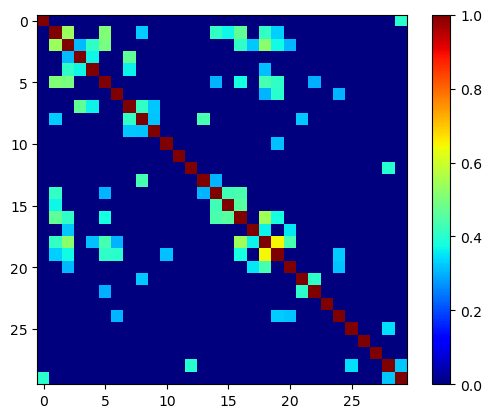

/var/folders/hr/cn8gd6d15xv_6m22yptdtyhw0000gn/T/ipykernel_42708/2089025335.py:6: RuntimeWarning: divide by zero encountered in divide
  graph = np.where(graph == 0, 0, 1 / graph)


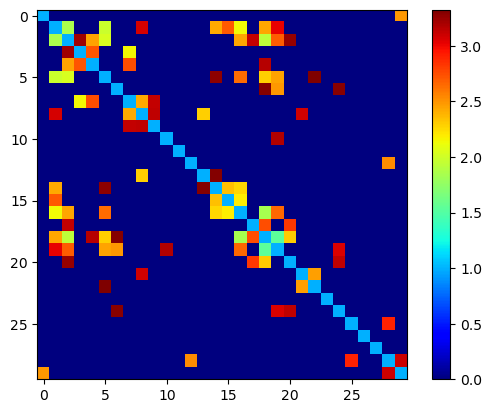

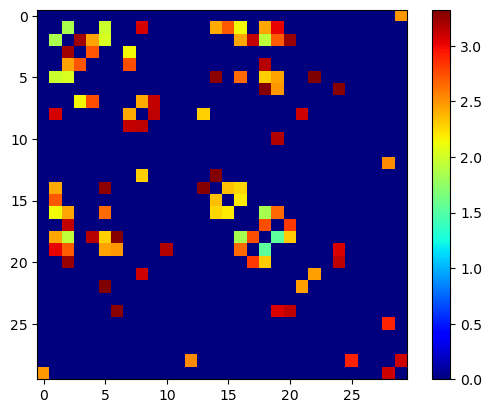

In [9]:
graph = mat_data["fconn"][:,:,1]
graph = np.where(graph < 0.3, 0,graph)
plt.imshow(graph, cmap=cmap)
plt.colorbar()
plt.show()
graph = np.where(graph == 0, 0, 1 / graph)
plt.imshow(graph, cmap=cmap)
plt.colorbar()
plt.show()
graph = np.where(graph == 1, 0, graph)
plt.imshow(graph, cmap=cmap)
plt.colorbar()
plt.show()

In [10]:
G = nx.from_numpy_array(graph)
G.edges(data=True)

EdgeDataView([(0, 29, {'weight': 2.493697241673712}), (1, 2, {'weight': 1.8565063141094766}), (1, 5, {'weight': 1.9828065220813516}), (1, 8, {'weight': 3.077925438551029}), (1, 14, {'weight': 2.4266843611629914}), (1, 15, {'weight': 2.708823252083137}), (1, 16, {'weight': 2.141066067953502}), (1, 18, {'weight': 2.4294678184370877}), (1, 19, {'weight': 3.019646981048841}), (2, 3, {'weight': 3.2319889778207926}), (2, 4, {'weight': 2.443935797437229}), (2, 5, {'weight': 2.0287994636695754}), (2, 16, {'weight': 2.4397908964556447}), (2, 17, {'weight': 3.118173866853813}), (2, 18, {'weight': 1.929935400854167}), (2, 19, {'weight': 2.690417469576039}), (2, 20, {'weight': 3.250551164473601}), (3, 4, {'weight': 2.721864023738333}), (3, 7, {'weight': 2.148910937453369}), (4, 7, {'weight': 2.748678023637966}), (4, 18, {'weight': 3.16217665477795}), (5, 14, {'weight': 3.284286826894551}), (5, 16, {'weight': 2.644787481363805}), (5, 18, {'weight': 2.2868742306246914}), (5, 19, {'weight': 2.4460437

In [11]:
bc = nx.betweenness_centrality(G,normalized=False,weight='weight')
bc

{0: 0.0,
 1: 38.0,
 2: 26.0,
 3: 0.0,
 4: 10.0,
 5: 22.0,
 6: 0.0,
 7: 8.0,
 8: 34.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 10.0,
 15: 0.0,
 16: 21.0,
 17: 0.0,
 18: 37.0,
 19: 42.0,
 20: 1.0,
 21: 4.0,
 22: 9.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 5.0,
 29: 3.0}

In [12]:
bcents = np.zeros((17,30))

# Computing BCs
for i in range(17):
    graph = mat_data["fconn"][:,:,1]
    graph = np.where(graph < 0.3, 0,graph)
    graph = np.where(graph == 0, 0, 1/graph)
    graph = np.where(graph == 1, 0, graph)
    G = nx.from_numpy_array(graph)
    bc = nx.betweenness_centrality(G,normalized=False,weight='weight')
    bc_arr = list(bc.values())
    bcents[i,:] = bc_arr

print(bcents[i])
feats[:,:,1] = bcents

[ 0. 38. 26.  0. 10. 22.  0.  8. 34.  0.  0.  0.  0.  0. 10.  0. 21.  0.
 37. 42.  1.  4.  9.  0.  0.  0.  0.  0.  5.  3.]


/var/folders/hr/cn8gd6d15xv_6m22yptdtyhw0000gn/T/ipykernel_42708/2582949302.py:7: RuntimeWarning: divide by zero encountered in divide
  graph = np.where(graph == 0, 0, 1/graph)


In [13]:
ecents = np.zeros((17,30))

# Computing BCs
for i in range(17):
    graph = mat_data["fconn"][:,:,1]
    graph = np.where(graph < 0.3, 0,graph)
    graph = np.where(graph == 1, 0, graph)
    G = nx.from_numpy_array(graph)
    ec = nx.eigenvector_centrality(G,weight='weight')
    ec_arr = list(ec.values())
    ecents[i,:] = ec_arr

print(ecents[i])
feats[:,:,2] = ecents

[6.32923169e-08 3.80141250e-01 3.92244886e-01 7.09749244e-02
 1.27201229e-01 3.49611795e-01 1.09284104e-01 4.12172861e-02
 6.17720625e-02 1.24715689e-02 4.11090662e-02 6.29495167e-12
 8.09124414e-08 3.19690562e-02 1.89569654e-01 1.48176019e-01
 3.72388303e-01 1.25025009e-01 4.23968055e-01 3.44713564e-01
 1.41060592e-01 1.40493411e-02 4.20042967e-02 6.29495167e-12
 7.23334007e-02 7.07283486e-08 6.29495167e-12 6.29495167e-12
 1.35872513e-07 1.04488921e-07]


In [14]:
feats

array([[[7.85488218e-01, 0.00000000e+00, 6.32923169e-08],
        [3.36712295e+00, 3.80000000e+01, 3.80141250e-01],
        [3.85056296e+00, 2.60000000e+01, 3.92244886e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 6.29495167e-12],
        [1.34455672e+00, 5.00000000e+00, 1.35872513e-07],
        [7.66633451e-01, 3.00000000e+00, 1.04488921e-07]],

       [[4.01010990e-01, 0.00000000e+00, 6.32923169e-08],
        [3.35895923e+00, 3.80000000e+01, 3.80141250e-01],
        [3.67818499e+00, 2.60000000e+01, 3.92244886e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 6.29495167e-12],
        [1.06247261e+00, 5.00000000e+00, 1.35872513e-07],
        [7.23582655e-01, 3.00000000e+00, 1.04488921e-07]],

       [[4.37431723e-01, 0.00000000e+00, 6.32923169e-08],
        [2.48667589e+00, 3.80000000e+01, 3.80141250e-01],
        [3.14094767e+00, 2.60000000e+01, 3.92244886e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 6.29495167e-12],
        [1.14417240e+00, 5.00

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(feats.reshape(-1,3)) 

print(scaled.shape)

print(scaled.reshape(17,30,3).shape)

scaled = scaled.flatten()
print(scaled.shape)


(510, 3)
(17, 30, 3)
(1530,)
